In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from collections import Counter
import re
import nltk
#import pymorphy2
from ast import literal_eval
import gensim

## Давайте посмотрим на наши данные


In [5]:
users = pd.read_csv("/content/drive/MyDrive/MTS_summer_school/users.csv")
users.head()

,user_id,age,sex
0,0,45_54,1.0
1,1,25_34,0.0
2,2,45_54,0.0
3,3,65_inf,0.0
4,4,18_24,0.0


In [6]:
items = pd.read_csv("/content/drive/MyDrive/MTS_summer_school/items.csv")
items.head()

,id,title,genres,authors,year
0,248031,Ворон-челобитчик,"Зарубежные детские книги,Сказки,Зарубежная кла...",Михаил Салтыков-Щедрин,1886
1,256084,Скрипка Ротшильда,"Классическая проза,Литература 19 века,Русская ...",Антон Чехов,1894
2,134166,Испорченные дети,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1869
3,281311,Странный человек,"Пьесы и драматургия,Литература 19 века",Михаил Лермонтов,1831
4,213473,Господа ташкентцы,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1873


In [7]:
interactions = pd.read_csv("/content/drive/MyDrive/MTS_summer_school/interactions.csv")
interactions.head()

,user_id,item_id,progress,rating,start_date
0,90133,82910,100,NaN,2018-01-01
1,159130,331068,70,NaN,2018-01-01
2,80061,26540,69,4.0,2018-01-01
3,12811,301895,16,NaN,2018-01-01
4,5778,127872,100,NaN,2018-01-01


### Замечаем два лютых выброса. Оно и логично, конечно, но скорее всего их придётся выбросить или крутить для них коэффициенты. 


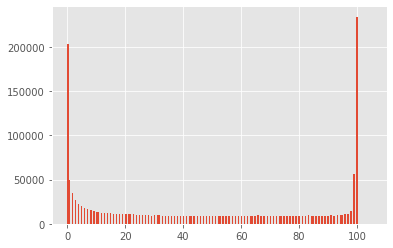

In [8]:
interactions.progress.hist(bins=200);

## Холодный старт

### В первую очередь поймём, что в рекомендательных системах есть проблема холодного старта. Что если пользователь новый? Что же ему посоветовать?


### Моя идея - для каждого типа людей выводить свой топ. Например, если ты девушка 27 лет, то тебе рекомендовать топовые книги среди девушек от 25 до 34.
### Nan по sex или age будем рассматривать как отдельный класс, то есть как третий пол :)


In [78]:
class Top():
    def __init__(self, users, interactions, items):
        # my_big_array = []
        self.my_big_dict = {}
        self.my_big_rating_dict = {}
        self.my_final_rating_dict = {}
        self.max_len = 0
        self.answer = {}
        self.my_big_users_dict = {}

        for i in users[["user_id", "age", "sex"]].values:
            self.my_big_users_dict[i[0]] = str(i[1]) + str(i[2])
            self.my_big_rating_dict[str(i[1]) + str(i[2])] = {}
            
        #GG = 5000
        for i in tqdm(interactions[["user_id", "item_id", "progress", "rating"]].values):  # Прекрасно понимаю, что не супер оптимальный алгоритм, но исправлю как-нибудь потом :) 
            '''
            GG -= 1
            if GG == 0:
                break
            '''
            self.max_len += 1
            #self.my_big_users_dict[i[0]]
            if i[0] in self.my_big_users_dict:
                my_current_agesex = self.my_big_users_dict[i[0]]
                if i[1] in self.my_big_rating_dict[my_current_agesex]:
                    if str(i[3]) != "nan" and str(i[2]) != "nan":
                        self.my_big_rating_dict[my_current_agesex][i[1]].append(int(i[2]) * int(i[3]))
                    elif str(i[2]) != "nan":
                        self.my_big_rating_dict[my_current_agesex][i[1]].append(int(i[2]) * 3.5)
                else:
                    if str(i[3]) != "nan" and str(i[2]) != "nan":
                        self.my_big_rating_dict[my_current_agesex][i[1]] = [int(i[2]) * int(i[3])]
                    elif str(i[2]) != "nan":
                        self.my_big_rating_dict[my_current_agesex][i[1]] = [int(i[2]) * 3.5]
                
        #print(self.my_big_rating_dict)
        for i in self.my_big_rating_dict.items():
            self.my_final_rating_dict[i[0]] = {}
            for j in i[1]:
                # print(i, j)
                self.my_final_rating_dict[i[0]][j] = (sum(self.my_big_rating_dict[i[0]][j]) / self.max_len) # (sum(self.my_big_rating_dict[i][j]) / len(self.my_big_rating_dict[i][j])) * (len(self.my_big_rating_dict[i][j]) / self.max_len)
            #print(self.my_final_rating_dict[i[0]].items())
            d = sorted(self.my_final_rating_dict[i[0]].items(), key=lambda x: x[1], reverse=True)
            #print(d)
            k = 0
            for j in d:
                if k == 0:
                    self.answer[i[0]] = [int(j[0])]
                else:
                    self.answer[i[0]].append(int(j[0]))
                k += 1
                if k == 10:
                    break
        # print(self.answer)
    def give_me_some_info(self, id):
        if id not in self.my_big_users_dict:
            return self.my_big_users_dict[0]
        else:
            return self.my_big_users_dict[id]

    def top_books(self, some_info):
        return self.answer[some_info]
        

In [79]:
T = Top(users, interactions, items)


100%|██████████| 1562617/1562617 [00:09<00:00, 165426.17it/s]


## Создаём табличку для отправки на Kaggle

In [80]:
Result_table = pd.read_csv("/content/drive/MyDrive/MTS_summer_school/sample_submission.csv")

In [90]:


result = []
for i in Result_table[['Id']].values:
    if i != 'Id':
        result.append(' '.join(map(str, T.top_books(T.give_me_some_info(int(i))))))
#print(result)
ser = pd.Series(result)
#print(ser)
Result_table['Predicted'] = ser
Result_table[["Id", "Predicted"]].to_csv("FINAL.csv", index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """
